In [1]:
import geopandas as gpd
import pandas as pd
import shapely
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from libpysal import graph

import preprocess_data

In [2]:
boundary_list = list(gpd.list_layers("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg").name)

In [3]:
aoi = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer="1994_political")
aoi = aoi.dissolve()

In [72]:
def generate_boundary_diagram(boundary_name, level="level_7", ax=False, width_multiplier=4, cmap='plasma'):
    """Generates a boundary diagram for a given layer."""
    boundary = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer=boundary_name)

    #Retrieve level-7 BC matrix for layer of interest
    bray_curtis_matrix = pd.read_parquet(f'/data/uscuni-ulce/boundaries_of_change/bc_matrices/bc_{boundary_name}_{level}.pq')

    #Segment boundaries between adjacent regions
    indices = boundary.sindex.query(boundary.geometry, predicate="intersects")
    left, right = np.unique(np.sort(indices, axis=0), axis=1)

    mask = left == right
    left = left[~mask]
    right = right[~mask]
    geoms = boundary.iloc[left].intersection(boundary.iloc[right], align=False)
    left = boundary.NAME.iloc[left]
    right = boundary.NAME.iloc[right]

    #Retrieve BC dissimilarity values between every two adjacent regions
    border_widths = []
    for l, r in zip(left, right):
        border_widths.append(bray_curtis_matrix.loc[l, r])

    #Recalculate border widths so that higher BC dissimilarity values are emphasized
    line_widths = [(0.1 + width_multiplier*(np.exp(2*w) - 1)) for w in border_widths]

    #Create a colormap to emphasize higher BC dissimilarity values between adjacent regions
    norm=plt.Normalize(0, .7)
    # cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["lightgray","black"])
    if isinstance(cmap, str):
        cmap = matplotlib.colormaps[cmap]

    #Plotting
    if ax:
        for geom, width, border in zip (geoms, line_widths, border_widths):
            gpd.GeoSeries([shapely.line_merge(geom)]).plot(ax=ax, linewidth=width, color=cmap(norm(border)))
            ax.set_title(f"{boundary_name}")
    else:
        fig, ax = plt.subplots()
        ax.set_title(boundary_name)
        for geom, width, border in zip (geoms, line_widths, border_widths):
            gpd.GeoSeries([shapely.line_merge(geom)]).plot(ax=ax, linewidth=width, color=cmap(norm(border)))

In [137]:
def generate_boundary_diagrams(boundary_lst, level, show_aoi=False, width_multiplier=4, cmap='plasma'):
    """Generates boundary diagrams for each layer in boundary_lst baseon on specified level."""
    fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(20,10), sharey=True)
    axs = axs.flatten()
    fig.suptitle(level)
    for i, boundary in enumerate(boundary_list):
        if show_aoi:
            aoi.plot(ax=axs[i], color='whitesmoke')
        generate_boundary_diagram(boundary, level, ax=axs[i], width_multiplier=width_multiplier, cmap=cmap)

    plt.tight_layout()

    for ax in axs:
        ax.set_axis_off()

In [167]:
def generate_bc_heatmaps_for_diagrams(boundary_name, level="level_7", ax=False, cmap='plasma'):
    boundary = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer=boundary_name)

    #Retrieve level-7 BC matrix for layer of interest
    bray_curtis_matrix = pd.read_parquet(f'/data/uscuni-ulce/boundaries_of_change/bc_matrices/bc_{boundary_name}_{level}.pq')
    mask = np.tril(bray_curtis_matrix, k=0)
    mask = np.where(mask<=0, True, False)
    #cbar_kws = {"shrink": 0.7}
    if ax:
        plt.figure(figsize = (6,2))
        sns.heatmap(bray_curtis_matrix, annot=True, cmap='plasma', ax=ax, mask=mask, linewidth=.5, vmin=0, vmax=0.7, cbar=False)
        ax.set_title(boundary_name)

    else:
        fig, ax = plt.subplots()
        sns.heatmap(bray_curtis_matrix, annot=True, cmap='plasma', ax=ax, mask=mask, linewidth=.5)
        ax.set_title(boundary_name)

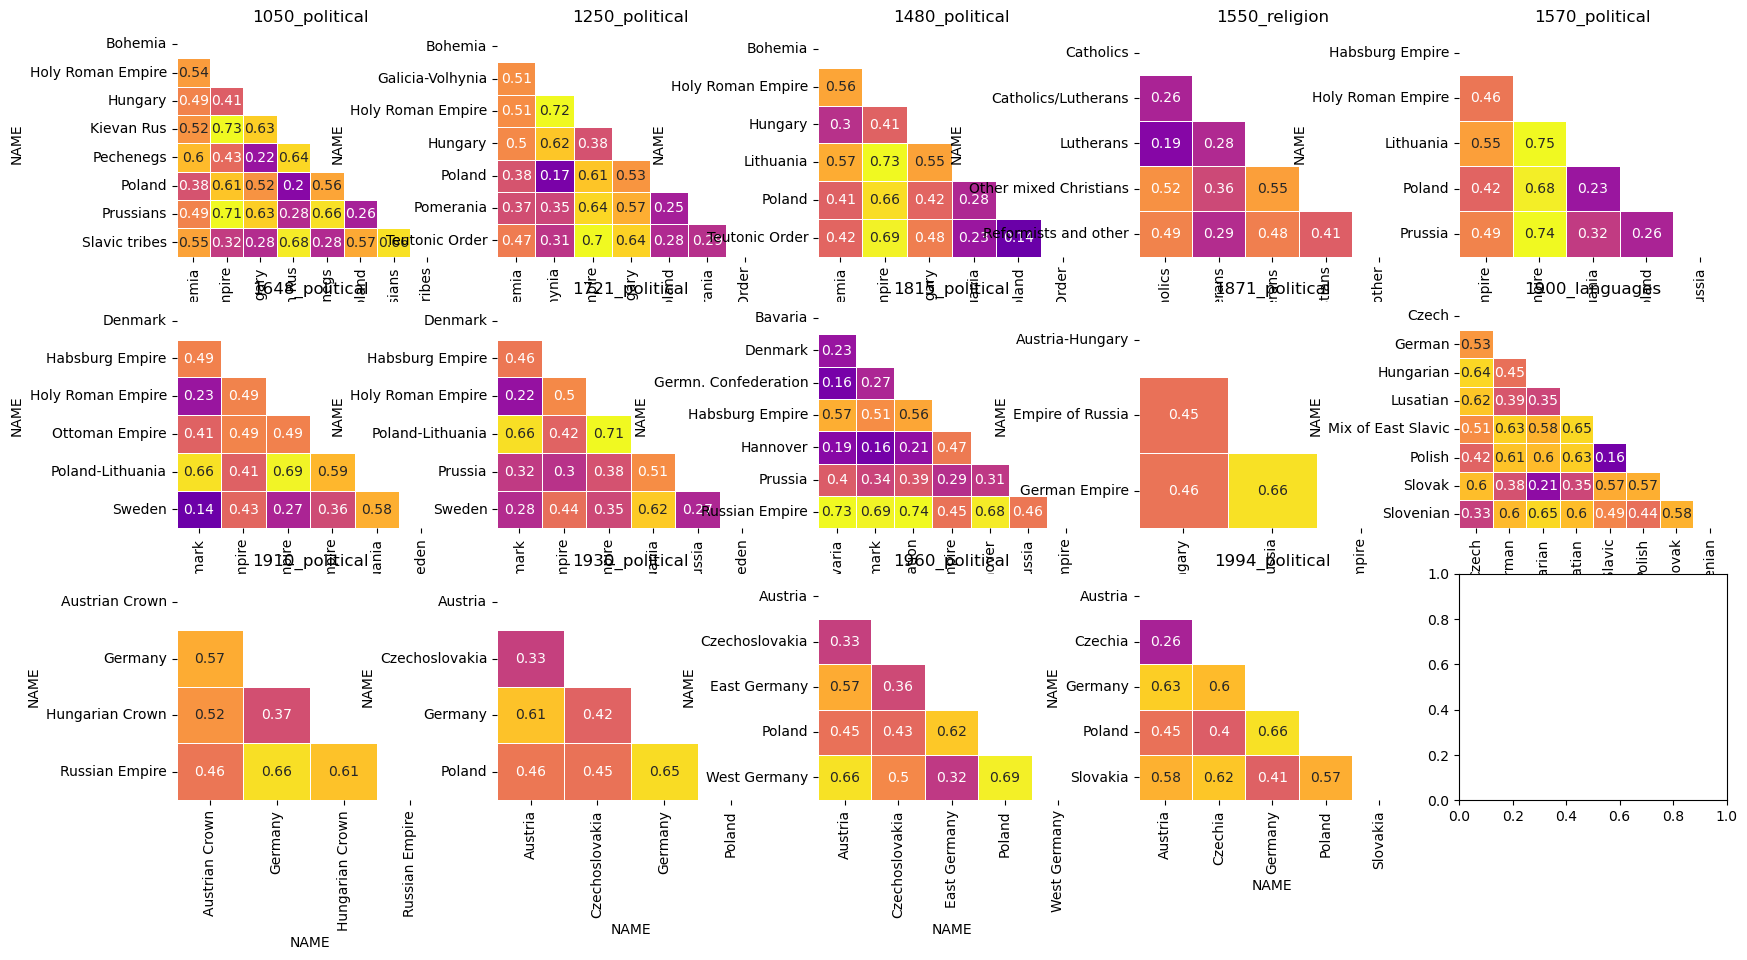

<Figure size 600x200 with 0 Axes>

<Figure size 600x200 with 0 Axes>

<Figure size 600x200 with 0 Axes>

<Figure size 600x200 with 0 Axes>

<Figure size 600x200 with 0 Axes>

<Figure size 600x200 with 0 Axes>

<Figure size 600x200 with 0 Axes>

<Figure size 600x200 with 0 Axes>

<Figure size 600x200 with 0 Axes>

<Figure size 600x200 with 0 Axes>

<Figure size 600x200 with 0 Axes>

<Figure size 600x200 with 0 Axes>

<Figure size 600x200 with 0 Axes>

<Figure size 600x200 with 0 Axes>

In [169]:
fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(20,10))
axs = axs.flatten()

for i, boundary in enumerate(boundary_list):
    generate_bc_heatmaps_for_diagrams(boundary, "level_7", ax=axs[i], cmap="plasma")

plt.tight_layout()

#for ax in axs:
#    ax.set_axis_off()

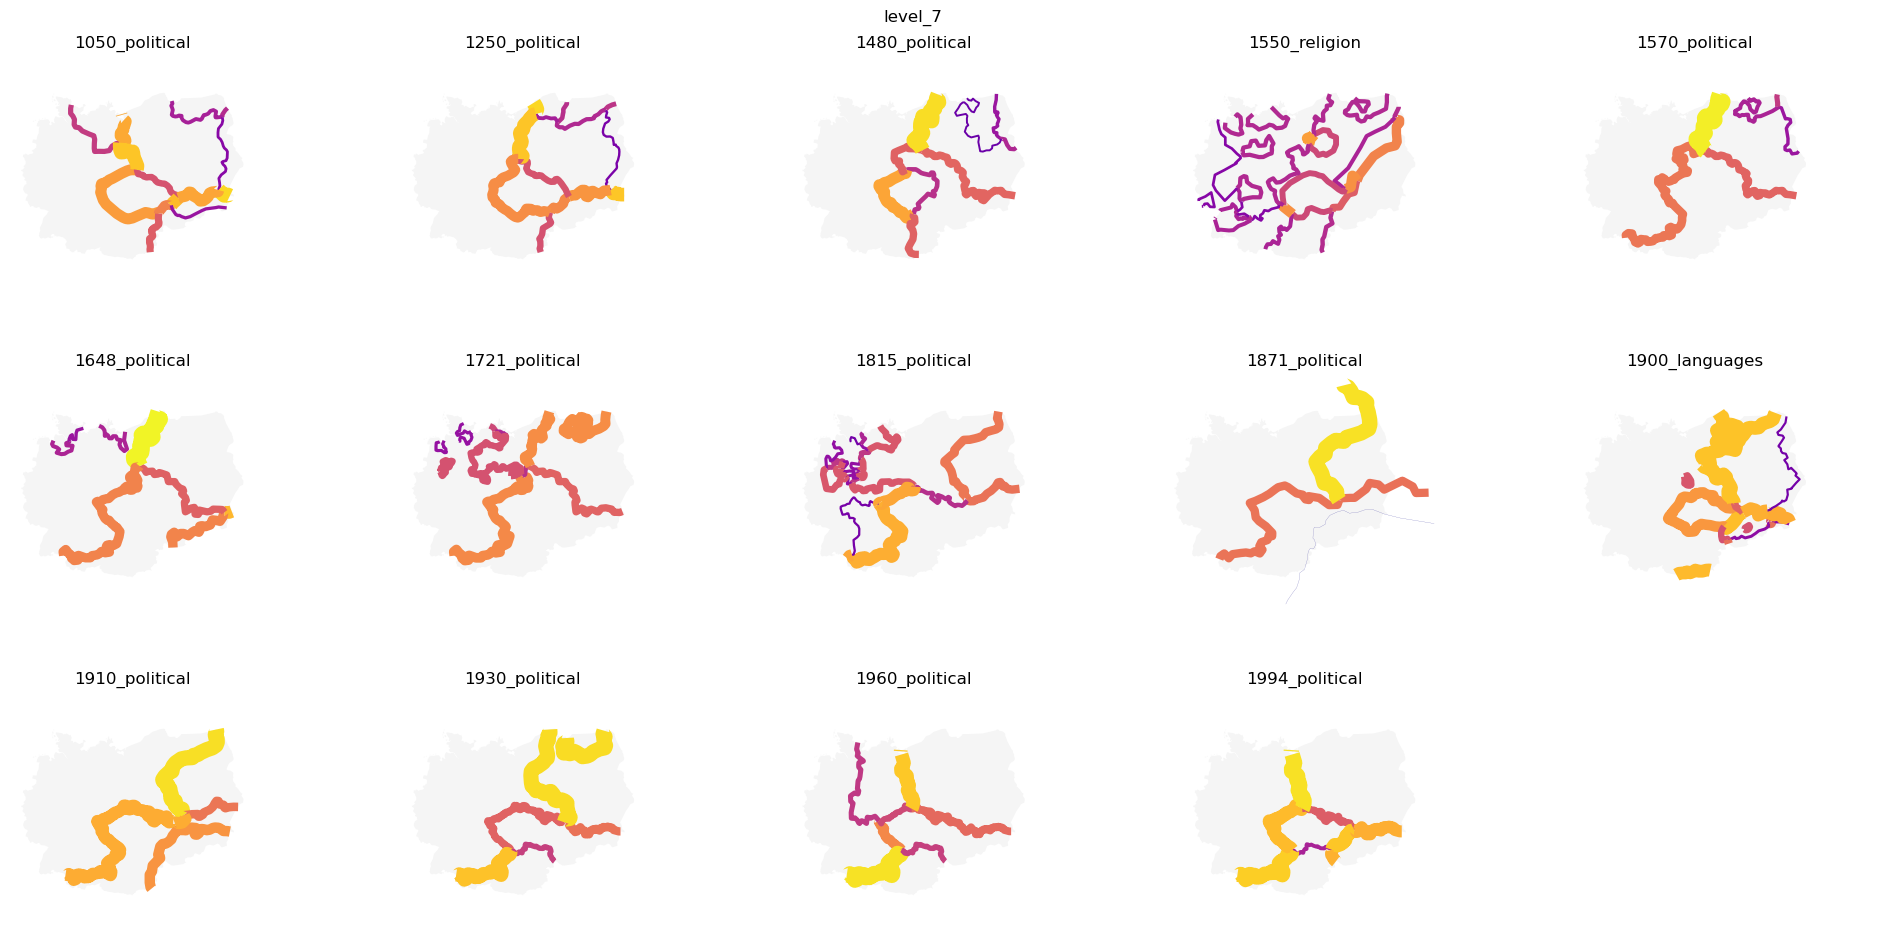

In [149]:
generate_boundary_diagrams(boundary_list, "level_7", show_aoi=True)

In [61]:
bray_curtis_matrix = pd.read_parquet(f'/data/uscuni-ulce/boundaries_of_change/bc_matrices/bc_1994_political_level_7.pq')
mask = np.tril(bray_curtis_matrix, k=0)


In [62]:
mask

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.26016164, 0.        , 0.        , 0.        , 0.        ],
       [0.63104046, 0.59750925, 0.        , 0.        , 0.        ],
       [0.44909494, 0.40368584, 0.66146211, 0.        , 0.        ],
       [0.57894112, 0.61786298, 0.41186873, 0.57249419, 0.        ]])

In [42]:
mask = np.where(mask==0,True,False)
mask

array(True)

array([[ True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True],
       [False, False,  True,  True,  True],
       [False, False, False,  True,  True],
       [False, False, False, False,  True]])